In [ ]:
# === 0) 경로/옵션 설정 ===
BASE_DIR = r"C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase"
PREFERRED_FILENAME = "olist_analysis_dataset.csv" 
OUT_DIR = fr"{BASE_DIR}\olist_outputs"
REPURCHASE_WINDOW_DAYS = 180 

import os
import glob
import pandas as pd
import numpy as np

os.makedirs(OUT_DIR, exist_ok=True)

# === 1) 사용할 CSV 경로 확정 ===
candidate = os.path.join(BASE_DIR, PREFERRED_FILENAME)
if os.path.isfile(candidate):
    MERGED_PATH = candidate
else:
    # 폴더 내 CSV 자동 탐색 → 가장 큰 파일 선택
    csvs = glob.glob(os.path.join(BASE_DIR, "*.csv"))
    if not csvs:
        raise FileNotFoundError(f"CSV 파일을 찾을 수 없습니다: {BASE_DIR}")
    # 크기 기준 내림차순 정렬
    csvs = sorted(csvs, key=lambda p: os.path.getsize(p), reverse=True)
    MERGED_PATH = csvs[0]

print("[INFO] Using file:", MERGED_PATH)
print("[INFO] Outputs ->", OUT_DIR)

# === 2) 데이터 로딩 ===
df = pd.read_csv(MERGED_PATH, low_memory=False)
print("[INFO] raw shape:", df.shape)

# === 3) 날짜/상태 정리 ===
if "order_purchase_timestamp" in df.columns:
    df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"], errors="coerce")

if "order_status" in df.columns:
    before = len(df)
    df = df[df["order_status"].astype(str).str.lower() == "delivered"].copy()
    print(f"[INFO] delivered only: {before} -> {len(df)} rows")

# === 4) 결제 금액 보정 ===
if "order_payment_value" not in df.columns:
    if "payment_value" in df.columns:
        _pay = df.groupby("order_id", as_index=False)["payment_value"].sum()
        _pay = _pay.rename(columns={"payment_value": "order_payment_value"})
        df = df.merge(_pay, on="order_id", how="left")
    elif set(["price", "freight_value", "order_id"]).issubset(df.columns):
        _pay = df.groupby("order_id", as_index=False)[["price", "freight_value"]].sum()
        _pay["order_payment_value"] = _pay["price"] + _pay["freight_value"]
        df = df.merge(_pay[["order_id", "order_payment_value"]], on="order_id", how="left")
    else:
        df["order_payment_value"] = np.nan

# === 5) 할부/지역/카테고리 보정 ===
if "order_payment_installments" not in df.columns:
    if "payment_installments" in df.columns:
        df = df.rename(columns={"payment_installments": "order_payment_installments"})
    else:
        df["order_payment_installments"] = 0

if "customer_state" not in df.columns:
    df["customer_state"] = "unknown"

if "product_category_name_english" in df.columns:
    df["product_category_name_english"] = df["product_category_name_english"].fillna("unknown")

# === 6) 정렬 ===
sort_cols = [c for c in ["customer_unique_id", "order_purchase_timestamp", "order_id"] if c in df.columns]
if sort_cols:
    df = df.sort_values(sort_cols)

# === 7) 빠른 진단 출력 ===
def exist(c): 
    return c in df.columns

print("\n[DIAG] Columns exist check:")
for c in ["customer_unique_id", "order_id", "order_purchase_timestamp",
          "product_category_name_english", "order_payment_value",
          "order_payment_installments", "customer_state"]:
    print(f" - {c}: {exist(c)}")

print("\n[DIAG] Date range (purchase):")
if "order_purchase_timestamp" in df.columns:
    print("   min:", df["order_purchase_timestamp"].min())
    print("   max:", df["order_purchase_timestamp"].max())

print("\n[DIAG] #customers / #orders")
n_cust = df["customer_unique_id"].nunique() if "customer_unique_id" in df.columns else None
n_orders = df["order_id"].nunique() if "order_id" in df.columns else None
print("   unique customers:", n_cust)
print("   unique orders   :", n_orders)

print("\n[DIAG] Null ratio (key cols):")
keys = ["customer_unique_id", "order_id", "order_purchase_timestamp",
        "product_category_name_english", "order_payment_value",
        "order_payment_installments", "customer_state"]
for k in keys:
    if k in df.columns:
        r = df[k].isna().mean()
        print(f"   {k:30s}: {r:.3%}")

print("\n[DIAG] Top categories (overall):")
if "product_category_name_english" in df.columns:
    print(df["product_category_name_english"].value_counts().head(15))

# === 8) 중간 저장(다음 단계에서 재사용) ===
clean_path = os.path.join(OUT_DIR, "step1_clean.csv")  # 파케로 저장하면 의존성 생겨서 CSV로 저장
df.to_csv(clean_path, index=False, encoding="utf-8-sig")
print("\n[SAVED] cleaned step1 ->", clean_path)

preview_path = os.path.join(OUT_DIR, "step1_preview.csv")
df.head(50).to_csv(preview_path, index=False, encoding="utf-8-sig")
print("[SAVED] preview ->", preview_path)


[INFO] Using file: C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_analysis_dataset.csv
[INFO] Outputs -> C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs
[INFO] raw shape: (108635, 5)

[DIAG] Columns exist check:
 - customer_unique_id: True
 - order_id: True
 - order_purchase_timestamp: True
 - product_category_name_english: True
 - order_payment_value: True
 - order_payment_installments: True
 - customer_state: True

[DIAG] Date range (purchase):
   min: 2016-10-03 09:44:50
   max: 2018-08-29 15:00:37

[DIAG] #customers / #orders
   unique customers: 92078
   unique orders   : 95126

[DIAG] Null ratio (key cols):
   customer_unique_id            : 0.000%
   order_id                      : 0.000%
   order_purchase_timestamp      : 0.000%
   product_category_name_english : 0.000%
   order_payment_value           : 0.000%
   order_payment_installments    : 0.000%
   customer_state                : 0.000%

[DIAG] Top catego

In [ ]:
# === 2단계: 구매 시퀀스 & 1→2 전환 페어 ===
import os
import pandas as pd
import numpy as np

BASE_DIR = r"C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase"
OUT_DIR  = fr"{BASE_DIR}\olist_outputs"
STEP1_CLEAN = fr"{OUT_DIR}\step1_clean.csv"

print("[INFO] Loading step1:", STEP1_CLEAN)
df = pd.read_csv(STEP1_CLEAN, low_memory=False)
print("[INFO] shape:", df.shape)

# 주문 단위 대표 테이블: (주문-고객-시간)별 첫 번째 카테고리를 대표로 사용
order_first_cat = (
    df.groupby(["order_id","customer_unique_id","order_purchase_timestamp"], as_index=False)
      .agg(first_cat=("product_category_name_english","first"),
           order_value=("order_payment_value","first"),
           installments=("order_payment_installments","first"),
           customer_state=("customer_state","first"))
)

# 고객별 주문 순번(시간 기준)
order_first_cat["order_purchase_timestamp"] = pd.to_datetime(order_first_cat["order_purchase_timestamp"], errors="coerce")
order_first_cat = order_first_cat.sort_values(["customer_unique_id", "order_purchase_timestamp"])
order_first_cat["order_rank"] = order_first_cat.groupby("customer_unique_id")["order_purchase_timestamp"] \
                                               .rank(method="first")

print("\n[CHECK] order_first_cat preview")
print(order_first_cat.head(5))

# 재구매 고객(주문 2회 이상)
order_counts = order_first_cat.groupby("customer_unique_id").size()
rep_ids = order_counts[order_counts >= 2].index
order_rep = order_first_cat[order_first_cat["customer_unique_id"].isin(rep_ids)].copy()

n_customers_total = order_first_cat["customer_unique_id"].nunique()
n_customers_rep   = len(rep_ids)
print(f"\n[STATS] customers total: {n_customers_total:,}")
print(f"[STATS] customers with >=2 orders: {n_customers_rep:,} ({n_customers_rep/n_customers_total:.1%})")

# 1→2 전환 테이블 생성
first_orders  = order_rep[order_rep["order_rank"] == 1.0][["customer_unique_id","first_cat"]]
second_orders = order_rep[order_rep["order_rank"] == 2.0][["customer_unique_id","first_cat"]] \
                .rename(columns={"first_cat":"second_cat"})
transitions = first_orders.merge(second_orders, on="customer_unique_id", how="inner")

# 전환 집계 및 Top30 추출
trans_counts = transitions.groupby(["first_cat","second_cat"]).size().reset_index(name="count")
top30 = trans_counts.sort_values("count", ascending=False).head(30)

# 저장
out_trans = os.path.join(OUT_DIR, "top30_transitions.csv")
order_first_cat_path = os.path.join(OUT_DIR, "order_first_cat.csv")  # 다음 단계 재사용
top30.to_csv(out_trans, index=False, encoding="utf-8-sig")
order_first_cat.to_csv(order_first_cat_path, index=False, encoding="utf-8-sig")

print(f"\n[SAVED] Top30 transitions -> {out_trans}")
print("[TOP30 transitions head]")
print(top30.head(10))

# 1→2가 아닌 전체 시퀀스 분석을 위해 고객별 전체 카테고리 리스트 확인용
seq_preview = (
    order_first_cat.sort_values(["customer_unique_id","order_purchase_timestamp"])
    .groupby("customer_unique_id")["first_cat"]
    .apply(list).head(5)
)
print("\n[PREVIEW] sample sequences (first 5 customers):")
for i,(cid, seq) in enumerate(seq_preview.items(), start=1):
    print(f"  {i:02d}. {cid} -> {seq}")


[INFO] Loading step1: C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\step1_clean.csv
[INFO] shape: (108635, 8)

[CHECK] order_first_cat preview
                               order_id                customer_unique_id  \
84245  e22acc9c116caa3f2b7121bbb380d08e  0000366f3b9a7992bf8c76cfdf3221e2   
19845  3594e05a005ac4d06a72673270ef9ec9  0000b849f77a49e4a4ce2b2a4ca5be3f   
66507  b33ec3b699337181488304f362a6b734  0000f46a3911fa3c0805444483337064   
24136  41272756ecddd9a9ed0180413cc22fb6  0000f6ccb0745a6a4b88665a16c9f078   
80886  d957021f1127559cd947b62533f484f7  0004aac84e0df4da2b147fca70cf8255   

      order_purchase_timestamp       first_cat  order_value  installments  \
84245      2018-05-10 10:56:27  bed_bath_table       141.90             0   
19845      2018-05-07 11:11:27   health_beauty        27.19             0   
66507      2017-03-10 21:05:03      stationery        86.22             0   
24136      2017-10-12 20:29:41       telephony 

In [4]:
# === 2단계 결과 요약만 출력 (STATS + Top10 전환) ===
import os, pandas as pd

BASE_DIR = r"C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase"
OUT_DIR  = fr"{BASE_DIR}\olist_outputs"
order_first_cat_path = os.path.join(OUT_DIR, "order_first_cat.csv")

df_ord = pd.read_csv(order_first_cat_path, low_memory=False)
df_ord["order_purchase_timestamp"] = pd.to_datetime(df_ord["order_purchase_timestamp"], errors="coerce")

# 재구매 고객 통계
order_counts = df_ord.groupby("customer_unique_id").size()
rep_ids = order_counts[order_counts >= 2].index

print("[STATS]")
print(f" - customers total: {df_ord['customer_unique_id'].nunique():,}")
print(f" - customers with >=2 orders: {len(rep_ids):,} "
      f"({len(rep_ids)/df_ord['customer_unique_id'].nunique():.1%})")

# 1→2 전환 계산 & Top10
order_rep = df_ord[df_ord["customer_unique_id"].isin(rep_ids)].copy()
first = order_rep[order_rep["order_rank"] == 1.0][["customer_unique_id","first_cat"]]
second = order_rep[order_rep["order_rank"] == 2.0][["customer_unique_id","first_cat"]].rename(columns={"first_cat":"second_cat"})
transitions = first.merge(second, on="customer_unique_id", how="inner")
top10 = (transitions.groupby(["first_cat","second_cat"]).size()
         .reset_index(name="count")
         .sort_values("count", ascending=False)
         .head(10))

print("\n[TOP10 transitions]")
print(top10.to_string(index=False))


[STATS]
 - customers total: 92,078
 - customers with >=2 orders: 2,742 (3.0%)

[TOP10 transitions]
               first_cat               second_cat  count
          bed_bath_table           bed_bath_table    220
          sports_leisure           sports_leisure    160
           health_beauty            health_beauty    140
   computers_accessories    computers_accessories    117
         furniture_decor          furniture_decor    115
           watches_gifts            watches_gifts     59
              housewares               housewares     54
         home_appliances          home_appliances     49
fashion_bags_accessories fashion_bags_accessories     46
               telephony                telephony     42


In [ ]:
# === 3단계: KPI & 관문 점수 ===
import os
import pandas as pd
import numpy as np

BASE_DIR = r"C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase"
OUT_DIR  = fr"{BASE_DIR}\olist_outputs"
ORDER_FIRST_CAT = os.path.join(OUT_DIR, "order_first_cat.csv")

REPURCHASE_WINDOW_DAYS = 180
MIN_CUSTOMERS = 50  

print("[INFO] Loading:", ORDER_FIRST_CAT)
ofc = pd.read_csv(ORDER_FIRST_CAT, low_memory=False)
ofc["order_purchase_timestamp"] = pd.to_datetime(ofc["order_purchase_timestamp"], errors="coerce")

# --- 고객별 180일 내 재구매 라벨 생성(1→2 주문 기준) ---
def label_repurchase_within_window(g: pd.DataFrame, window_days: int) -> pd.Series:
    g = g.sort_values("order_purchase_timestamp")
    if len(g) < 2:
        return pd.Series({"repurchased_within_window": 0, "days_to_second": np.nan})
    t1 = g.iloc[0]["order_purchase_timestamp"]
    t2 = g.iloc[1]["order_purchase_timestamp"]
    days = (t2 - t1).days if pd.notnull(t1) and pd.notnull(t2) else np.nan
    return pd.Series({
        "repurchased_within_window": int(pd.notnull(days) and days <= window_days),
        "days_to_second": days
    })

cust_labels = (
    ofc.groupby("customer_unique_id")
       .apply(label_repurchase_within_window, REPURCHASE_WINDOW_DAYS)
       .reset_index()
)

# --- 첫 구매 정보(피처) 테이블 ---
first_order = ofc.sort_values(["customer_unique_id","order_purchase_timestamp"])
first_order = first_order[first_order["order_rank"] == 1.0][
    ["customer_unique_id","first_cat","order_value","installments","customer_state","order_purchase_timestamp"]
]

cust_first = first_order.merge(cust_labels, on="customer_unique_id", how="left")

# --- KPI 계산 ---
kpi = cust_first.groupby("first_cat").agg(
    customers=("customer_unique_id","nunique"),
    repurchase_rate=("repurchased_within_window","mean"),
    avg_days_to_second=("days_to_second","mean"),
    avg_first_value=("order_value","mean")
).reset_index()

# LTV: 고객별 총구매액 → 첫 카테고리 그룹 평균
totals = ofc.groupby("customer_unique_id").agg(total_value=("order_value","sum")).reset_index()
kpi = kpi.merge(
    first_order[["customer_unique_id","first_cat"]].merge(totals, on="customer_unique_id")
        .groupby("first_cat").agg(avg_LTV=("total_value","mean")).reset_index(),
    on="first_cat", how="left"
)

# 관문 점수: (정규화 LTV) × (재구매율)
def minmax_norm(s: pd.Series) -> pd.Series:
    s = s.copy()
    if s.max() == s.min():
        return pd.Series(np.ones_like(s), index=s.index)
    return (s - s.min()) / (s.max() - s.min())

kpi["repurchase_rate"] = kpi["repurchase_rate"].fillna(0.0)
kpi["avg_LTV"] = kpi["avg_LTV"].fillna(0.0)
kpi["norm_LTV"] = minmax_norm(kpi["avg_LTV"])
kpi["gateway_score"] = kpi["norm_LTV"] * kpi["repurchase_rate"]

# 저장
kpi_all_path = os.path.join(OUT_DIR, "kpi_gateway_scores_all.csv")
kpi.to_csv(kpi_all_path, index=False, encoding="utf-8-sig")

kpi_filt = kpi[kpi["customers"] >= MIN_CUSTOMERS].sort_values("gateway_score", ascending=False)
kpi_filt_path = os.path.join(OUT_DIR, "kpi_gateway_scores_filtered.csv")
kpi_filt.to_csv(kpi_filt_path, index=False, encoding="utf-8-sig")

# 콘솔 요약 출력
print("\n[SAVED]")
print(" - all :", kpi_all_path)
print(" - filt:", kpi_filt_path)

print("\n[TOP10 by gateway_score] (filtered)")
with pd.option_context("display.max_rows", 20, "display.max_columns", None, "display.width", 120):
    print(kpi_filt.head(10))

print("\n[Bottom10 by gateway_score] (filtered)")
with pd.option_context("display.max_rows", 20, "display.max_columns", None, "display.width", 120):
    print(kpi_filt.tail(10))

[INFO] Loading: C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\order_first_cat.csv


C:\Users\jso25\AppData\Local\Temp\ipykernel_19520\80839884.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(label_repurchase_within_window, REPURCHASE_WINDOW_DAYS)



[SAVED]
 - all : C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\kpi_gateway_scores_all.csv
 - filt: C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\kpi_gateway_scores_filtered.csv

[TOP10 by gateway_score] (filtered)
                                first_cat  customers  repurchase_rate  avg_days_to_second  avg_first_value  \
38                      furniture_bedroom         83         0.060241           10.400000       357.306747   
1                        air_conditioning        236         0.042373           48.727273       369.315169   
45                      home_appliances_2        217         0.023041            2.200000       535.582903   
64  small_appliances_home_oven_and_coffee         72         0.013889            0.000000       698.356250   
14                              computers        173         0.005780            0.000000      1559.798324   
57                       office_furniture      

In [6]:
# === 4단계: 180일 내 재구매 예측 베이스라인 ===
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

BASE_DIR = r"C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase"
OUT_DIR  = fr"{BASE_DIR}\olist_outputs"
ORDER_FIRST_CAT = os.path.join(OUT_DIR, "order_first_cat.csv")
RESULT_TXT      = os.path.join(OUT_DIR, "model_results.txt")
FI_CSV          = os.path.join(OUT_DIR, "feature_importances_rf.csv")

REPURCHASE_WINDOW_DAYS = 180

# 1) 데이터 로드
ofc = pd.read_csv(ORDER_FIRST_CAT, low_memory=False)
ofc["order_purchase_timestamp"] = pd.to_datetime(ofc["order_purchase_timestamp"], errors="coerce")

# 2) 고객별 180일 내 재구매 라벨(1→2 주문 기준)
def label_repurchase(g: pd.DataFrame, window_days: int) -> pd.Series:
    g = g.sort_values("order_purchase_timestamp")
    if len(g) < 2:
        return pd.Series({"repurchased_within_window": 0, "days_to_second": np.nan})
    t1 = g.iloc[0]["order_purchase_timestamp"]
    t2 = g.iloc[1]["order_purchase_timestamp"]
    days = (t2 - t1).days if pd.notnull(t1) and pd.notnull(t2) else np.nan
    return pd.Series({
        "repurchased_within_window": int(pd.notnull(days) and days <= window_days),
        "days_to_second": days
    })

cust_labels = ofc.groupby("customer_unique_id").apply(label_repurchase, REPURCHASE_WINDOW_DAYS).reset_index()

# 3) 첫 구매 피처 테이블
first_order = (
    ofc.sort_values(["customer_unique_id","order_purchase_timestamp"])
       .query("order_rank == 1.0")[["customer_unique_id","first_cat","order_value","installments","customer_state"]]
)
data = first_order.merge(cust_labels[["customer_unique_id","repurchased_within_window"]], on="customer_unique_id", how="left")

# 4) X, y 구성
y = data["repurchased_within_window"].fillna(0).astype(int)
X = data[["first_cat","order_value","installments","customer_state"]].copy()

# 결측/형 변환
X["order_value"] = pd.to_numeric(X["order_value"], errors="coerce").fillna(0.0)
X["installments"] = pd.to_numeric(X["installments"], errors="coerce").fillna(0.0)
X["first_cat"] = X["first_cat"].fillna("unknown")
X["customer_state"] = X["customer_state"].fillna("unknown")

num_cols = ["order_value","installments"]
cat_cols = ["first_cat","customer_state"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# 5) Train/Test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6) 두 모델 비교: 로지스틱, 랜덤포레스트
models = {
    "logreg": LogisticRegression(max_iter=200),
    "random_forest": RandomForestClassifier(n_estimators=300, random_state=42)
}

results_txt = []
for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:,1] if hasattr(clf, "predict_proba") else pipe.decision_function(X_test)
    auc = roc_auc_score(y_test, proba)
    y_pred = (proba >= 0.5).astype(int)
    report = classification_report(y_test, y_pred, zero_division=0)
    results_txt.append(f"[{name}] AUC={auc:.4f}\n{report}\n")

# 7) 결과 저장/출력
with open(RESULT_TXT, "w", encoding="utf-8") as f:
    f.write("\n".join(results_txt))

print("[RESULTS] saved ->", RESULT_TXT)
print("\n".join(results_txt))

# 8) 랜덤포레스트 피처중요도 저장
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf_pipe = Pipeline([("prep", preprocess), ("clf", rf)])
rf_pipe.fit(X_train, y_train)

ohe = rf_pipe.named_steps["prep"].named_transformers_["cat"]
ohe_cols = list(ohe.get_feature_names_out(cat_cols))
full_cols = num_cols + ohe_cols

fi = pd.DataFrame({"feature": full_cols, "importance": rf_pipe.named_steps["clf"].feature_importances_}) \
       .sort_values("importance", ascending=False)
fi.to_csv(FI_CSV, index=False, encoding="utf-8-sig")
print("[FEATURE IMPORTANCES] saved ->", FI_CSV)
print(fi.head(20).to_string(index=False))


C:\Users\jso25\AppData\Local\Temp\ipykernel_19520\1468298290.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cust_labels = ofc.groupby("customer_unique_id").apply(label_repurchase, REPURCHASE_WINDOW_DAYS).reset_index()
c:\Users\jso25\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

[RESULTS] saved -> C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\model_results.txt
[logreg] AUC=0.5991
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17961
           1       0.00      0.00      0.00       455

    accuracy                           0.98     18416
   macro avg       0.49      0.50      0.49     18416
weighted avg       0.95      0.98      0.96     18416


[random_forest] AUC=0.5239
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     17961
           1       0.02      0.01      0.02       455

    accuracy                           0.96     18416
   macro avg       0.50      0.50      0.50     18416
weighted avg       0.95      0.96      0.96     18416


[FEATURE IMPORTANCES] saved -> C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\feature_importances_rf.csv
                                

C:\Users\jso25\AppData\Local\Temp\ipykernel_19520\2185772701.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_df = df.groupby("customer_unique_id").apply(label_repurchase).reset_index()
c:\Users\jso25\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 400 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=400).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

AUC: 0.5971
Best threshold(F1): 0.6035   F1: 0.0832   P: 0.0539   R: 0.1824

Report @best_thr
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     17961
           1       0.05      0.18      0.08       455

    accuracy                           0.90     18416
   macro avg       0.52      0.55      0.52     18416
weighted avg       0.96      0.90      0.93     18416

Confusion matrix:
 [[16502  1459]
 [  372    83]]


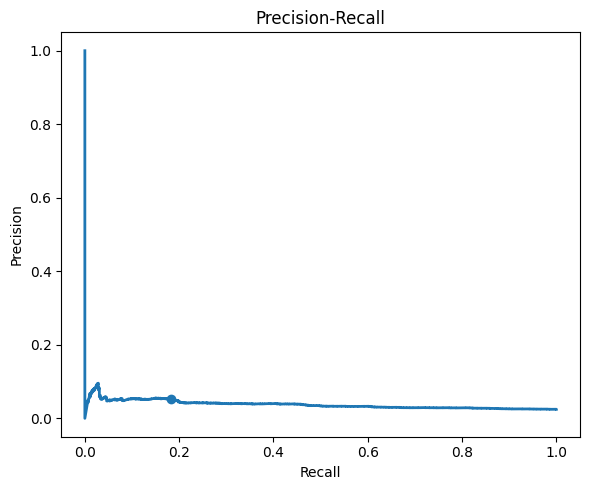

In [7]:
# A. 임계값 튜닝 + 불균형 보정(class_weight) + PR 커브 저장

# === A) Logistic + class_weight + 임계값 튜닝 ===
import os, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt

BASE_DIR = r"C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase"
OFCP = os.path.join(BASE_DIR, r"olist_outputs\order_first_cat.csv")
OUT = os.path.join(BASE_DIR, r"olist_outputs")
os.makedirs(OUT, exist_ok=True)

df = pd.read_csv(OFCP)
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"], errors="coerce")

def label_repurchase(g, window_days=180):
    g = g.sort_values("order_purchase_timestamp")
    if len(g) < 2: return pd.Series({"y":0})
    d = (g.iloc[1]["order_purchase_timestamp"]-g.iloc[0]["order_purchase_timestamp"]).days
    return pd.Series({"y": int(pd.notnull(d) and d<=window_days)})

y_df = df.groupby("customer_unique_id").apply(label_repurchase).reset_index()
X_df = (df.sort_values(["customer_unique_id","order_purchase_timestamp"])
          .query("order_rank==1.0")[["customer_unique_id","first_cat","order_value","installments","customer_state"]])
data = X_df.merge(y_df, on="customer_unique_id", how="left").fillna({"y":0})

y = data["y"].astype(int)
X = data[["first_cat","order_value","installments","customer_state"]].copy()
X["order_value"] = pd.to_numeric(X["order_value"], errors="coerce").fillna(0.0)
X["installments"] = pd.to_numeric(X["installments"], errors="coerce").fillna(0.0)
X["first_cat"] = X["first_cat"].fillna("unknown")
X["customer_state"] = X["customer_state"].fillna("unknown")

num_cols = ["order_value","installments"]
cat_cols = ["first_cat","customer_state"]

pre = ColumnTransformer([
    ("num","passthrough", num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])

# 불균형 보정
clf = LogisticRegression(max_iter=400, class_weight="balanced", solver="lbfgs")
pipe = Pipeline([("pre", pre), ("clf", clf)])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
pipe.fit(X_tr, y_tr)
proba = pipe.predict_proba(X_te)[:,1]
auc = roc_auc_score(y_te, proba)
print("AUC:", round(auc, 4))

# F1 최대 임계값
prec, rec, thr = precision_recall_curve(y_te, proba)
f1s = 2*prec*rec/(prec+rec+1e-12)
best_i = int(np.nanargmax(f1s))
best_thr = float(thr[best_i-1]) if 0 < best_i < len(thr) else 0.5
print("Best threshold(F1):", round(best_thr,4), "  F1:", round(float(f1s[best_i]),4),
      "  P:", round(float(prec[best_i]),4), "  R:", round(float(rec[best_i]),4))

# 임계값 적용 리포트/혼동행렬
y_pred = (proba >= best_thr).astype(int)
print("\nReport @best_thr")
print(classification_report(y_te, y_pred, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))

# PR 커브 저장
plt.figure(figsize=(6,5))
plt.plot(rec, prec, linewidth=2)
plt.scatter(rec[best_i], prec[best_i])
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "pr_curve_logreg_balanced.png"))
plt.show()

# 임계값 기록
with open(os.path.join(OUT, "logreg_balanced_threshold.txt"), "w", encoding="utf-8") as f:
    f.write(f"AUC={auc:.4f}\nBest_thr={best_thr:.4f}\nF1={f1s[best_i]:.4f}\n")


In [ ]:
# B. 캠페인 타깃 CSV 만들기 (확률 + 세그먼트)

# === B) 전체 고객 스코어링 & 세그먼트 CSV ===
import os, pandas as pd, numpy as np

BASE_DIR = r"C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase"
OFCP = os.path.join(BASE_DIR, r"olist_outputs\order_first_cat.csv")
OUT = os.path.join(BASE_DIR, r"olist_outputs")

# (A)에서 학습한 pipe, best_thr 재사용을 가정
ofc = pd.read_csv(OFCP)
ofc["order_purchase_timestamp"] = pd.to_datetime(ofc["order_purchase_timestamp"], errors="coerce")

first = (ofc.sort_values(["customer_unique_id","order_purchase_timestamp"])
           .query("order_rank==1.0")[["customer_unique_id","first_cat","order_value","installments","customer_state"]]).copy()

X_all = first[["first_cat","order_value","installments","customer_state"]].copy()
X_all["order_value"] = pd.to_numeric(X_all["order_value"], errors="coerce").fillna(0.0)
X_all["installments"] = pd.to_numeric(X_all["installments"], errors="coerce").fillna(0.0)
X_all["first_cat"] = X_all["first_cat"].fillna("unknown")
X_all["customer_state"] = X_all["customer_state"].fillna("unknown")

first["p_repurchase_180d"] = pipe.predict_proba(X_all)[:,1]
first["segment"] = np.where(first["p_repurchase_180d"] >= best_thr, "HIGH", "LOW")

# 상위 관문 카테고리/전환 타깃 규칙(예시)
rules = {
    "computers": "keyboards_mice or storage",
    "air_conditioning": "filters or power_plugs",
    "home_appliances_2": "accessories_bundle",
    "furniture_bedroom": "home_textile or decor_small",
    "telephony": "cases_cables or earbuds"
}
first["next_offer_hint"] = first["first_cat"].map(rules).fillna("generic_cross_sell")

out_csv = os.path.join(OUT, "campaign_scoring_180d.csv")
first.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("Saved ->", out_csv)
print(first.head(10))


Saved -> C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\campaign_scoring_180d.csv
                 customer_unique_id                 first_cat  order_value  \
0  0000366f3b9a7992bf8c76cfdf3221e2            bed_bath_table       141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f             health_beauty        27.19   
2  0000f46a3911fa3c0805444483337064                stationery        86.22   
3  0000f6ccb0745a6a4b88665a16c9f078                 telephony        43.62   
4  0004aac84e0df4da2b147fca70cf8255                 telephony       196.89   
5  0004bd2a26a76fe21f786e4fbd80607f              garden_tools       166.98   
6  00050ab1314c0e55a6ca13cf7181fecf                 telephony        35.38   
7  00053a61a98854899e70ed204dd4bafe            sports_leisure       838.36   
8  0005e1862207bf6ccc02e4228effd9a0  fashion_bags_accessories       150.12   
9  0005ef4cd20d2893f0d9fbd94d3c0d97            sports_leisure       129.76   

   installments custo

### 시각화

In [16]:
# =========================
# Olist Visualization Pack
# =========================
import os, pandas as pd, numpy as np
import matplotlib.pyplot as plt

# 0) 경로 설정
BASE_DIR = "C:\\Users\\jso25\\OneDrive\\Desktop\\CLUB\\EPOCH\\mini_project\\first_purchase\\"
OUT_DIR  = os.path.join(BASE_DIR, "olist_outputs")
CHART_DIR = os.path.join(OUT_DIR, "olist_charts")
os.makedirs(CHART_DIR, exist_ok=True)

# 1) 파일 로드
ofc_path   = os.path.join(OUT_DIR, "order_first_cat.csv")
trans_path = os.path.join(OUT_DIR, "top30_transitions.csv")
kpi_path_f = os.path.join(OUT_DIR, "kpi_gateway_scores_filtered.csv")
kpi_path_a = os.path.join(OUT_DIR, "kpi_gateway_scores_all.csv")
scoring_path = os.path.join(OUT_DIR, "campaign_scoring_180d.csv")

ofc = pd.read_csv(ofc_path, low_memory=False)
ofc["order_purchase_timestamp"] = pd.to_datetime(ofc["order_purchase_timestamp"], errors="coerce")

trans = pd.read_csv(trans_path) if os.path.isfile(trans_path) else None
kpi = pd.read_csv(kpi_path_f) if os.path.isfile(kpi_path_f) else pd.read_csv(kpi_path_a)
scoring = pd.read_csv(scoring_path) if os.path.isfile(scoring_path) else None

In [17]:
# 2) 보조함수: 고객 라벨(y) 계산 (180일 내 재구매 여부)
def label_repurchase(g: pd.DataFrame, window_days=180):
    g = g.sort_values("order_purchase_timestamp")
    if len(g) < 2: 
        return pd.Series({"y":0, "days_to_second": np.nan})
    t1, t2 = g.iloc[0]["order_purchase_timestamp"], g.iloc[1]["order_purchase_timestamp"]
    days = (t2 - t1).days if pd.notnull(t1) and pd.notnull(t2) else np.nan
    return pd.Series({"y": int(pd.notnull(days) and days<=window_days), "days_to_second": days})

cust_stats = ofc.groupby("customer_unique_id").apply(label_repurchase).reset_index()

C:\Users\jso25\AppData\Local\Temp\ipykernel_19520\2842877382.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cust_stats = ofc.groupby("customer_unique_id").apply(label_repurchase).reset_index()


In [18]:
# 3) 1→2 전환 Sankey (plotly가 있으면 Sankey, 없으면 상위 전환 쌍 막대 대체)
def plot_sankey(trans_df):
    try:
        import plotly.graph_objects as go
        # 상위 전환 사용 (이미 top30면 그대로)
        df = trans_df.copy().sort_values("count", ascending=False).head(30)
        # 노드 인덱스 매핑
        cats = pd.unique(df[["first_cat","second_cat"]].values.ravel("K"))
        idx = {c:i for i,c in enumerate(cats)}
        source = df["first_cat"].map(idx)
        target = df["second_cat"].map(idx)
        value  = df["count"]
        fig = go.Figure(data=[go.Sankey(
            node=dict(label=list(cats), pad=20, thickness=15),
            link=dict(source=source, target=target, value=value)
        )])
        fig.update_layout(title="1→2 Category Transitions (Top 30)", font_size=12)
        html_path = os.path.join(CHART_DIR, "sankey_1to2_top30.html")
        fig.write_html(html_path)
        print("[SAVED] Sankey HTML ->", html_path)
    except Exception as e:
        # 대체: 상위 전환 10개를 쌍 라벨로 묶은 막대
        df = trans_df.copy().sort_values("count", ascending=False).head(10)
        df["pair"] = df["first_cat"] + " → " + df["second_cat"]
        plt.figure(figsize=(10,5))
        plt.barh(df["pair"][::-1], df["count"][::-1])
        plt.title("1→2 Transitions (Top 10)"); plt.xlabel("Count"); plt.tight_layout()
        p = os.path.join(CHART_DIR, "sankey_fallback_top10.png")
        plt.savefig(p, dpi=150); plt.close()
        print("[SAVED] Fallback transition bar ->", p, "| Error:", e)

if trans is not None and len(trans):
    plot_sankey(trans)

[SAVED] Sankey HTML -> C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\olist_charts\sankey_1to2_top30.html


In [19]:
# 4) 관문 점수 Top/Bottom 막대
def ensure_gateway_score(df):
    # 관문 점수가 없으면 계산: norm_LTV * repurchase_rate
    if "gateway_score" not in df.columns:
        # LTV 없으면 0 처리
        df["avg_LTV"] = df.get("avg_LTV", pd.Series([0]*len(df)))
        # 정규화
        x = df["avg_LTV"].astype(float).fillna(0.0)
        if x.max() > x.min():
            norm = (x - x.min())/(x.max()-x.min())
        else:
            norm = pd.Series(np.ones_like(x), index=x.index)
        df["gateway_score"] = norm * df["repurchase_rate"].astype(float).fillna(0.0)
    return df

kpi = ensure_gateway_score(kpi.copy())
kpi_f = kpi.sort_values("gateway_score", ascending=False)

def bar_top_bottom(df, col="gateway_score", n=10):
    top = df.head(n).copy()
    bot = df.tail(n).copy()
    # Top
    plt.figure(figsize=(10,5))
    plt.barh(top["first_cat"][::-1], top[col][::-1])
    plt.title(f"Gateway Score Top {n}"); plt.xlabel("Gateway Score")
    plt.tight_layout()
    p1 = os.path.join(CHART_DIR, f"gateway_top{n}.png")
    plt.savefig(p1, dpi=150); plt.close()
    # Bottom
    plt.figure(figsize=(10,5))
    plt.barh(bot["first_cat"], bot[col])
    plt.title(f"Gateway Score Bottom {n}"); plt.xlabel("Gateway Score")
    plt.tight_layout()
    p2 = os.path.join(CHART_DIR, f"gateway_bottom{n}.png")
    plt.savefig(p2, dpi=150); plt.close()
    print("[SAVED] ->", p1, " / ", p2)

bar_top_bottom(kpi_f, n=10)

[SAVED] -> C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\olist_charts\gateway_top10.png  /  C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\olist_charts\gateway_bottom10.png


In [20]:
# 5) LTV vs 재구매율 버블(점 크기=고객 수)
def bubble_value_vs_rate(df):
    d = df.copy()
    d["customers"] = d.get("customers", pd.Series([np.nan]*len(d))).fillna(50)  # 최소 표시
    plt.figure(figsize=(8,6))
    s = (d["customers"] / d["customers"].max()*1200).clip(30, 1200)  # 마커 사이즈
    plt.scatter(d["avg_LTV"], d["repurchase_rate"], s=s, alpha=0.6)
    # 라벨 일부 표시(상위 몇 개만)
    show = d.sort_values(["repurchase_rate","avg_LTV"], ascending=False).head(12)
    for _, r in show.iterrows():
        plt.text(r["avg_LTV"], r["repurchase_rate"], str(r["first_cat"])[:18], fontsize=8)
    plt.xlabel("Average LTV"); plt.ylabel("Repurchase Rate (180d)")
    plt.title("Category Landscape: LTV vs Repurchase Rate")
    plt.tight_layout()
    p = os.path.join(CHART_DIR, "bubble_ltv_vs_rate.png")
    plt.savefig(p, dpi=150); plt.close()
    print("[SAVED] ->", p)

bubble_value_vs_rate(kpi_f)

[SAVED] -> C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\olist_charts\bubble_ltv_vs_rate.png


In [21]:
# 6) 2차 구매까지 걸린 기간 분포(Top 카테고리)
def days_to_second_by_cat(ofc, top_n=5, min_customers=50):
    # 고객별 days_to_second, first_cat
    ofc_sorted = ofc.sort_values(["customer_unique_id","order_purchase_timestamp"])
    first_ = ofc_sorted[ofc_sorted["order_rank"]==1.0][["customer_unique_id","first_cat"]]
    lbl = ofc.groupby("customer_unique_id").apply(label_repurchase).reset_index()
    df = first_.merge(lbl, on="customer_unique_id", how="left")
    # 카테고리별 고객수 기준 상위 N
    sizes = df.groupby("first_cat")["customer_unique_id"].nunique().sort_values(ascending=False)
    top_cats = sizes[sizes>=min_customers].head(top_n).index.tolist()
    sub = df[df["first_cat"].isin(top_cats) & df["days_to_second"].notna()].copy()
    if len(sub)==0:
        return
    # 박스플롯
    plt.figure(figsize=(10,5))
    data = [sub[sub["first_cat"]==c]["days_to_second"] for c in top_cats]
    plt.boxplot(data, labels=top_cats, showfliers=False)
    plt.ylabel("Days to 2nd Purchase"); plt.title(f"Top {len(top_cats)} Categories: Days to 2nd Purchase")
    plt.tight_layout()
    p = os.path.join(CHART_DIR, "days_to_second_box.png")
    plt.savefig(p, dpi=150); plt.close()
    print("[SAVED] ->", p)

days_to_second_by_cat(ofc, top_n=5, min_customers=50)

[SAVED] -> C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\olist_charts\days_to_second_box.png


C:\Users\jso25\AppData\Local\Temp\ipykernel_19520\2756838035.py:6: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\jso25\AppData\Local\Temp\ipykernel_19520\2756838035.py:17: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



In [22]:
# 7) 디사일 리프트·누적 포착율 (scoring + true y)
def decile_lift(scoring, ofc):
    if scoring is None or len(scoring)==0:
        print("[WARN] campaign_scoring_180d.csv not found -> skip decile")
        return
    # y 병합
    ydf = ofc.groupby("customer_unique_id").apply(label_repurchase).reset_index()
    df = scoring.merge(ydf[["customer_unique_id","y"]], on="customer_unique_id", how="left").fillna({"y":0})
    df = df.sort_values("p_repurchase_180d", ascending=False).reset_index(drop=True)
    N = len(df)
    df["rank"] = np.arange(1, N+1)
    df["decile"] = ((df["rank"]-1)/(N/10)).astype(int) + 1
    df.loc[df["decile"]>10, "decile"]=10
    dec = df.groupby("decile").agg(
        n=("customer_unique_id","count"),
        positives=("y","sum"),
        avg_p=("p_repurchase_180d","mean")
    ).reset_index()
    dec["cum_n"] = dec["n"].cumsum()
    dec["cum_pos"] = dec["positives"].cumsum()
    total_pos = df["y"].sum() if df["y"].sum()>0 else 1
    dec["capture_rate"] = dec["cum_pos"] / total_pos
    dec_path = os.path.join(CHART_DIR, "decile_table.csv")
    dec.to_csv(dec_path, index=False, encoding="utf-8-sig")
    print("[SAVED] decile table ->", dec_path)
    # 그래프: 누적 포착율
    plt.figure(figsize=(7,5))
    plt.plot(dec["decile"], dec["capture_rate"], marker="o")
    plt.xticks(range(1,11))
    plt.xlabel("Decile (1=Top)"); plt.ylabel("Cumulative Capture Rate")
    plt.title("Cumulative Capture by Decile")
    plt.grid(alpha=0.3); plt.tight_layout()
    p1 = os.path.join(CHART_DIR, "decile_capture_rate.png")
    plt.savefig(p1, dpi=150); plt.close()
    # 그래프: 디사일별 평균 예측확률
    plt.figure(figsize=(7,5))
    plt.bar(dec["decile"], dec["avg_p"])
    plt.xticks(range(1,11))
    plt.xlabel("Decile (1=Top)"); plt.ylabel("Avg predicted prob.")
    plt.title("Avg Score by Decile")
    plt.tight_layout()
    p2 = os.path.join(CHART_DIR, "decile_avg_prob.png")
    plt.savefig(p2, dpi=150); plt.close()
    print("[SAVED] ->", p1, " / ", p2)

decile_lift(scoring, ofc)

C:\Users\jso25\AppData\Local\Temp\ipykernel_19520\2214240408.py:7: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



[SAVED] decile table -> C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\olist_charts\decile_table.csv
[SAVED] -> C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\olist_charts\decile_capture_rate.png  /  C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\olist_charts\decile_avg_prob.png


In [23]:
# 8) PR 커브 (scoring + true y)
def plot_pr(scoring, ofc):
    try:
        from sklearn.metrics import precision_recall_curve, average_precision_score
    except Exception as e:
        print("[WARN] scikit-learn not available for PR curve:", e)
        return
    if scoring is None or len(scoring)==0:
        print("[WARN] scoring not found -> skip PR curve")
        return
    ydf = ofc.groupby("customer_unique_id").apply(label_repurchase).reset_index()
    df = scoring.merge(ydf[["customer_unique_id","y"]], on="customer_unique_id", how="left").fillna({"y":0})
    y = df["y"].astype(int).values
    p = df["p_repurchase_180d"].astype(float).values
    prec, rec, thr = precision_recall_curve(y, p)
    ap = average_precision_score(y, p)
    baseline = y.mean()
    plt.figure(figsize=(6,5))
    plt.plot(rec, prec, linewidth=2)
    plt.axhline(baseline, linestyle="--", linewidth=1)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve (AP={ap:.3f}, baseline={baseline:.3f})")
    plt.tight_layout()
    pth = os.path.join(CHART_DIR, "pr_curve.png")
    plt.savefig(pth, dpi=150); plt.close()
    print("[SAVED] ->", pth)

plot_pr(scoring, ofc)

print("\n[DONE] Charts saved in:", CHART_DIR)

[SAVED] -> C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\olist_charts\pr_curve.png

[DONE] Charts saved in: C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\olist_charts


C:\Users\jso25\AppData\Local\Temp\ipykernel_19520\3996347810.py:11: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



----

In [24]:
# =========================
# Sankey: 180일 내 재구매 고객만 (깨끗한 좌-우 레이아웃)
# =========================
import os, pandas as pd, numpy as np

import plotly.graph_objects as go

# === 경로 설정 ===
BASE_DIR = r"C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase"
OUT_DIR  = os.path.join(BASE_DIR, "olist_outputs")
CHART_DIR = os.path.join(OUT_DIR, "olist_charts")
os.makedirs(CHART_DIR, exist_ok=True)

OFCP = os.path.join(OUT_DIR, "order_first_cat.csv")  # 앞 단계 산출물
REPURCHASE_WINDOW_DAYS = 180

# === 1) 데이터 로드 & 준비 ===
ofc = pd.read_csv(OFCP, low_memory=False)
ofc["order_purchase_timestamp"] = pd.to_datetime(ofc["order_purchase_timestamp"], errors="coerce")
ofc = ofc.sort_values(["customer_unique_id","order_purchase_timestamp"])

# 고객별 1→2 사이 일수 계산(라벨)
def label_repurchase(g: pd.DataFrame, window_days: int = 180) -> pd.Series:
    g = g.sort_values("order_purchase_timestamp")
    if len(g) < 2:
        return pd.Series({"y":0, "days_to_second": np.nan})
    t1 = g.iloc[0]["order_purchase_timestamp"]
    t2 = g.iloc[1]["order_purchase_timestamp"]
    days = (t2 - t1).days if pd.notnull(t1) and pd.notnull(t2) else np.nan
    return pd.Series({"y": int(pd.notnull(days) and days <= window_days), "days_to_second": days})

lbl = ofc.groupby("customer_unique_id").apply(label_repurchase, REPURCHASE_WINDOW_DAYS).reset_index()

# 첫/두 번째 카테고리 붙이기
first = ofc.query("order_rank == 1.0")[["customer_unique_id","first_cat"]]
second = ofc.query("order_rank == 2.0")[["customer_unique_id","first_cat"]].rename(columns={"first_cat":"second_cat"})
pairs = (first.merge(second, on="customer_unique_id", how="inner")
              .merge(lbl[["customer_unique_id","y","days_to_second"]], on="customer_unique_id", how="left"))

# === 2) 180일 내 재구매만 필터 ===
rep = pairs.query("y == 1").copy()

# 전환 집계
t = rep.groupby(["first_cat","second_cat"]).size().reset_index(name="count")

# 각 first_cat 내 점유율 계산
tot_first = t.groupby("first_cat")["count"].sum().rename("total_first")
t = t.merge(tot_first, on="first_cat")
t["share"] = t["count"] / t["total_first"]

# === 3) 보기 좋게 필터링(자잘한 링크 제거) ===
MIN_SHARE = 0.06   # first_cat 내부 점유율 6% 이상만
MIN_COUNT = 20     # 최소 건수 20 이상만
t_f = t[(t["share"] >= MIN_SHARE) & (t["count"] >= MIN_COUNT)].copy()

# first_cat 규모 기준 상위만 남기고 싶으면(선택)
TOP_LEFT = 12
left_rank = t.groupby("first_cat")["count"].sum().sort_values(ascending=False).head(TOP_LEFT).index
t_f = t_f[t_f["first_cat"].isin(left_rank)]

# === 4) Sankey용 좌-우 노드 분리(루프 제거) ===
left_nodes  = sorted(t_f["first_cat"].unique().tolist())
right_nodes = sorted(t_f["second_cat"].unique().tolist())

labels = [f"{c} (1st)" for c in left_nodes] + [f"{c} (2nd)" for c in right_nodes]
index_left  = {c:i for i,c in enumerate(left_nodes)}
index_right = {c:i+len(left_nodes) for i,c in enumerate(right_nodes)}

# 링크
source = t_f["first_cat"].map(index_left).tolist()
target = t_f["second_cat"].map(index_right).tolist()
value  = t_f["count"].tolist()

# hover 텍스트(건수/점유율)
hover = (
    "From: " + t_f["first_cat"] + "<br>" +
    "To: " + t_f["second_cat"] + "<br>" +
    "Count: " + t_f["count"].astype(str) + "<br>" +
    "Share in first_cat: " + (t_f["share"]*100).round(1).astype(str) + "%"
)

# 노드 위치(왼쪽 0.01, 오른쪽 0.99)로 고정해 깔끔하게
x = [0.01]*len(left_nodes) + [0.99]*len(right_nodes)
# y는 균등 간격 배치
def linspace(n): 
    if n==1: return [0.5]
    return list(np.linspace(0.05, 0.95, n))
y = linspace(len(left_nodes)) + linspace(len(right_nodes))

fig = go.Figure(data=[go.Sankey(
    arrangement="fixed",
    node=dict(
        label=labels,
        x=x, y=y,
        pad=18, thickness=16,
        line=dict(width=0.3, color="gray")
    ),
    link=dict(
        source=source, target=target, value=value,
        hovertemplate=hover
    )
)])
fig.update_layout(
    title=f"1→2 Category Transitions within {REPURCHASE_WINDOW_DAYS} days (repurchasers only)",
    font_size=12, margin=dict(l=30,r=30,t=60,b=30)
)

html_path = os.path.join(CHART_DIR, f"sankey_repurchase_{REPURCHASE_WINDOW_DAYS}d.html")
fig.write_html(html_path)
print("[SAVED] ->", html_path)

# (옵션) 표도 같이 저장: 상위 전환 20개
top_tbl = (t_f.sort_values("count", ascending=False)
             .head(20)[["first_cat","second_cat","count","share"]].copy())
top_tbl["share_pct"] = (top_tbl["share"]*100).round(1)
csv_path = os.path.join(CHART_DIR, f"transitions_repurchase_{REPURCHASE_WINDOW_DAYS}d_top20.csv")
top_tbl.drop(columns=["share"]).to_csv(csv_path, index=False, encoding="utf-8-sig")
print("[SAVED] table ->", csv_path)


[SAVED] -> C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\olist_charts\sankey_repurchase_180d.html
[SAVED] table -> C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase\olist_outputs\olist_charts\transitions_repurchase_180d_top20.csv


C:\Users\jso25\AppData\Local\Temp\ipykernel_19520\1754811173.py:32: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



### SHAP

In [ ]:
# ==========================================
# LightGBM + SHAP (180일 재구매 예측 설명) — patched
# ==========================================
# - order_first_cat.csv 기반
# - Train/Valid 성능 출력(AUC)
# - SHAP 전역/개별 설명 이미지/HTML 저장
# - (옵션) 상위 5% 고객 Force Plot 대량 생성
# ------------------------------------------
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import shap
import lightgbm as lgb

from sklearn import __version__ as sk_version
from packaging.version import Version
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

# 경로 설정
BASE_DIR  = r"C:\Users\jso25\OneDrive\Desktop\CLUB\EPOCH\mini_project\first_purchase"
OUT_DIR   = os.path.join(BASE_DIR, "olist_outputs")
CHART_DIR = os.path.join(OUT_DIR, "olist_charts"); os.makedirs(CHART_DIR, exist_ok=True)

OFCP = os.path.join(OUT_DIR, "order_first_cat.csv")
SCOR = os.path.join(OUT_DIR, "campaign_scoring_180d.csv")
REPURCHASE_WINDOW_DAYS = 180

# 옵션
N_EXPLAIN = 20000      # SHAP 전역 요약용 샘플 크기(속도/메모리 보호)
GENERATE_TOP5P = False # 상위 5% 고객 Force Plot HTML 대량 생성 여부

# 1) 데이터 로드 및 정렬
ofc = pd.read_csv(OFCP, low_memory=False)
ofc["order_purchase_timestamp"] = pd.to_datetime(ofc["order_purchase_timestamp"], errors="coerce")
ofc = ofc.sort_values(["customer_unique_id","order_purchase_timestamp"])

# 2) 첫 구매 피처 X, 라벨 y(180일 내 재구매)
first = ofc.query("order_rank==1.0")[["customer_unique_id","first_cat","order_value","installments","customer_state"]].copy()

def label_repurchase(g, window_days=180):
    g = g.sort_values("order_purchase_timestamp")
    if len(g) < 2:
        return pd.Series({"y":0})
    d = (g.iloc[1]["order_purchase_timestamp"] - g.iloc[0]["order_purchase_timestamp"]).days
    return pd.Series({"y": int(pd.notnull(d) and d<=window_days)})

ydf = ofc.groupby("customer_unique_id", group_keys=False).apply(label_repurchase).reset_index()

data = first.merge(ydf, on="customer_unique_id", how="left").fillna({"y": 0})
y_all = data["y"].astype(int)

X_all = first[["first_cat","order_value","installments","customer_state"]].copy()
X_all["order_value"]    = pd.to_numeric(X_all["order_value"], errors="coerce").fillna(0.0)
X_all["installments"]   = pd.to_numeric(X_all["installments"], errors="coerce").fillna(0.0)
X_all["first_cat"]      = X_all["first_cat"].fillna("unknown")
X_all["customer_state"] = X_all["customer_state"].fillna("unknown")

# 3) 전처리(원핫) + LightGBM 파이프라인
num_cols = ["order_value","installments"]
cat_cols = ["first_cat","customer_state"]

# sklearn 버전별 sparse 옵션 호환
if Version(sk_version) >= Version("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

pre = ColumnTransformer([
    ("num", "passthrough", num_cols),  # 트리모델은 스케일 불필요
    ("cat", ohe, cat_cols),
])

# 불균형 보정: scale_pos_weight = 음성/양성
X_tr, X_te, y_tr, y_te = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)
pos = int(y_tr.sum()); neg = len(y_tr) - pos
spw = (neg / max(pos, 1)) if pos > 0 else 1.0

lgbm = LGBMClassifier(
    objective="binary",
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=spw,
)

pipe = Pipeline([("pre", pre), ("clf", lgbm)])

# 4) 학습 + 검증(AUC) — 콜백 기반 조기종료 & 무로그
pipe.fit(
    X_tr, y_tr,
    clf__eval_set=[(X_te, y_te)],
    clf__eval_metric="auc",
    clf__callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=False),
        lgb.log_evaluation(period=0),
    ],
)

auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:,1])
print(f"[INFO] LightGBM valid AUC: {auc:.4f}")

best_iter = pipe.named_steps["clf"].best_iteration_
if best_iter is not None:
    pipe.named_steps["clf"].set_params(n_estimators=best_iter)

# (선택) 전체 데이터로 재적합(해석/스코어용 일관성)
pipe.fit(X_all, y_all)

# 5) 전처리 후 피처 이름 & 행렬
ohe_model = pipe.named_steps["pre"].named_transformers_["cat"]
ohe_names = list(ohe_model.get_feature_names_out(cat_cols))
feature_names = num_cols + ohe_names

preproc = pipe.named_steps["pre"]
def transform_dense(X):
    Xenc = preproc.transform(X)
    try:
        return Xenc.toarray()
    except Exception:
        return np.array(Xenc)

# 6) SHAP 계산 (TreeExplainer)
clf = pipe.named_steps["clf"]
explainer = shap.TreeExplainer(clf)

rng = np.random.RandomState(42)
idx = rng.choice(len(X_all), size=min(N_EXPLAIN, len(X_all)), replace=False)
X_all_sample = X_all.iloc[idx]
X_enc_sample = transform_dense(X_all_sample)

shap_vals = explainer.shap_values(X_enc_sample)
if isinstance(shap_vals, list):
    shap_vals_use = shap_vals[1]  # 양성 클래스
    base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value
else:
    shap_vals_use = shap_vals
    base_value = explainer.expected_value

# 7) 전역 요약 플롯 저장 (bar + beeswarm)
plt.figure()
shap.summary_plot(shap_vals_use, X_enc_sample, feature_names=feature_names, show=False, plot_type="bar")
p1 = os.path.join(CHART_DIR, "lgbm_shap_summary_bar.png")
plt.tight_layout(); plt.savefig(p1, dpi=160); plt.close()

plt.figure()
shap.summary_plot(shap_vals_use, X_enc_sample, feature_names=feature_names, show=False)
p2 = os.path.join(CHART_DIR, "lgbm_shap_beeswarm.png")
plt.tight_layout(); plt.savefig(p2, dpi=160); plt.close()
print("[SAVED] ->", p1, " / ", p2)

# 8) 상위 고객(Top 5) 개별 Force Plot HTML
if os.path.isfile(SCOR):
    sc = pd.read_csv(SCOR)
    top_ids = sc.sort_values("p_repurchase_180d", ascending=False).head(5)["customer_unique_id"].tolist()
else:
    proba_all = pipe.predict_proba(X_all)[:,1]
    top_ids = (data.assign(p=proba_all)
                  .sort_values("p", ascending=False)
                  .head(5)["customer_unique_id"].tolist())

id_to_idx = {cid:i for i,cid in enumerate(data["customer_unique_id"])}

for cid in top_ids:
    i = id_to_idx[cid]
    X_row = transform_dense(X_all.iloc[[i]])
    sv_row = explainer.shap_values(X_row)
    if isinstance(sv_row, list):
        sv_row_use = sv_row[1]
        base_val = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value
    else:
        sv_row_use = sv_row
        base_val = explainer.expected_value
    fp = shap.force_plot(base_val, sv_row_use[0], X_row[0], feature_names=feature_names, matplotlib=False)
    html_path = os.path.join(CHART_DIR, f"lgbm_shap_force_{cid}.html")
    shap.save_html(html_path, fp)
    print("[SAVED] ->", html_path)

# 9) 원-핫 그룹 중요도(카테고리/지역 묶음)
abs_mean = np.abs(shap_vals_use).mean(axis=0)
grp = []
for j, name in enumerate(feature_names):
    if name.startswith("first_cat_"):
        grp.append("first_cat(카테고리)")
    elif name.startswith("customer_state_"):
        grp.append("customer_state(지역)")
    else:
        grp.append(name)

group_df = pd.DataFrame({"feature": feature_names, "group": grp, "abs_mean_shap": abs_mean})
group_imp = (group_df.groupby("group", as_index=False)["abs_mean_shap"]
                      .sum()
                      .sort_values("abs_mean_shap", ascending=False))

group_imp.to_csv(os.path.join(CHART_DIR, "lgbm_shap_group_importance.csv"), index=False, encoding="utf-8-sig")

plt.figure(figsize=(7,4))
plt.barh(group_imp["group"][::-1], group_imp["abs_mean_shap"][::-1])
plt.title("LightGBM - Grouped SHAP Importance"); plt.tight_layout()
p3 = os.path.join(CHART_DIR, "lgbm_shap_group_importance.png")
plt.savefig(p3, dpi=160); plt.close()
print("[SAVED] ->", p3)

# 10) (옵션) 상위 5% 고객 Force Plot 대량 생성
if GENERATE_TOP5P:
    if os.path.isfile(SCOR):
        sc = pd.read_csv(SCOR)
        k = max(1, int(len(sc)*0.05))
        top_ids = sc.sort_values("p_repurchase_180d", ascending=False).head(k)["customer_unique_id"].tolist()
    else:
        proba_all = pipe.predict_proba(X_all)[:,1]
        tmp = data.assign(p=proba_all).sort_values("p", ascending=False)
        k = max(1, int(len(tmp)*0.05))
        top_ids = tmp.head(k)["customer_unique_id"].tolist()

    for cid in top_ids:
        i = id_to_idx[cid]
        X_row = transform_dense(X_all.iloc[[i]])
        sv_row = explainer.shap_values(X_row)
        if isinstance(sv_row, list):
            sv_row_use = sv_row[1]; base_val = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value
        else:
            sv_row_use = sv_row; base_val = explainer.expected_value
        fp = shap.force_plot(base_val, sv_row_use[0], X_row[0], feature_names=feature_names, matplotlib=False)
        html_path = os.path.join(CHART_DIR, f"lgbm_shap_force_top5p_{cid}.html")
        shap.save_html(html_path, fp)
    print(f"[SAVED] top5% SHAP force plots -> {CHART_DIR}")

print("\n[DONE] LightGBM+SHAP artifacts saved in:", CHART_DIR)
